# Ensemble Learning and Random FOrests

Bagging is multiple decision trees trained on random samples of data -> (with replacement, means with putting it back).
<br> > Repeats items and can also miss some items.

Pasting is just bagging but without replacement (not putting the data back into the sampling pool).
<br> > Doesn't repeat items 



In [1]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.datasets import load_iris, make_hastie_10_2
from sklearn import metrics

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
X, y = make_hastie_10_2(random_state=0)
X_train, X_test = X[:2000], X[2000:]
y_train, y_test = y[:2000], y[2000:]

In [4]:
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
tree_clf = DecisionTreeClassifier(max_depth=2)
svm_clf = SVC()
voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],voting='hard')

In [5]:
# the following code trains an emsemble of 500 decision tree classifiers, 
# each trained on 100 training instances randmoly sampled from the training set (with replacement).

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

### Boosting: combines several weak learners into a stronger learner. 

## AdaBoosting

* Boosting is achieved by training a sequence of weak learners (decision stumps).
* Each learner is trained on the data with a set of sample weights that emphasize the mistakes of the previous learners.
* After each learner is trained, its weighted error is calculated, and its influence (alpha) is computed.
* The sample weights are then updated: samples that were misclassified get higher weights, so the next learner focuses more on them.
* This process is repeated for n_estimators rounds, resulting in an ensemble where each learner corrects the mistakes of the previous ones.
<br><br>

1. Initially every weight $w_i = 1/m$

2. First predictor is trained and it's error is computed: $r_i = \frac{\sum w_i  [ \hat y_i \neq y_i ]}{\sum w_i}$

3. Model weight is computed based on weighted error: $\alpha_i = \eta \log(\frac{1-r_i}{r_i})$

4. Weights are updated: $w_i \leftarrow w_i \cdot \exp(-\alpha_i * y_i * \hat y_i)$

5. Normalize weights by dividing them by $\sum w_i$

6. Repeat steps 2 - 5 with with updated weights until the desired number of predictors is reached

7. To make predictions, AdaBoost simply computes the predictions of all the predictors and weighs them using the predictor weights $\alpha_i$. <br>The predicted class is the one with maximum occurance.

In [6]:
iris = load_iris()
X = iris.data 
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=34)

In [7]:
class AdaBoost:
    def __init__(self, n_estimators=50, learning_rate=1):
        self.n_estimators=n_estimators
        self.learning_rate = learning_rate
        self.models = []
        self.alphas = []

    # Boosting
    def fit(self, X, y):
        n_samples = X.shape[0]
        # initialize sample weights
        w = np.ones(n_samples) / n_samples

        for _ in range(self.n_estimators):
            # 1. Train a weak learner 
            model = DecisionTreeClassifier(max_depth=1) # mini tree stump
            model.fit(X, y, sample_weight=w)

            # 2. make prediction and compute error
            predictions = model.predict(X)
            error = np.sum(w * (predictions != y))/np.sum(w)

            # 3. calculate model's alpha (influence)
            alpha = self.learning_rate * 0.5 * np.log((1 - error)/error)

            # 4. update the instance weights
            w *= np.exp(-alpha * y * predictions)

            # 5. normalize weights
            w /= np.sum(w)

            self.models.append(model)
            self.alphas.append(alpha)


    def predict(self, X):
        # initial predictions, just a bunch of zeros
        strong_preds = np.zeros(X.shape[0])

        # For each model and its alpha, we add the weighted prediction to the strong_preds array.
        # This loop aggregates the predictions of all weak learners, each weighted by its alpha (influence).
        for model, alpha in zip(self.models, self.alphas):
            strong_preds += alpha * model.predict(X)

        # We use np.sign to convert the aggregated weighted predictions (strong_preds)
        # into final class labels (-1 or 1). AdaBoost combines weak learners' outputs
        # as weighted votes; np.sign gives the final predicted class.
        return np.sign(strong_preds)
    



In [8]:
adaboost = AdaBoost(n_estimators=100)
adaboost.fit(X_train, y_train)

y_pred = adaboost.predict(X_test)

accuracy = metrics.accuracy_score(y_test, y_pred)
accuracy

0.8666666666666667

### Using sklearn

In [9]:
from sklearn.ensemble import AdaBoostClassifier

In [10]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=100, algorithm="SAMME", learning_rate=0.5)
ada_clf.fit(X_train, y_train)
new_preds = ada_clf.predict(X_test)

accuracy = metrics.accuracy_score(y_test, new_preds)
accuracy

c:\Users\108pa\Parth\Machine Learning Playground\machine_learning_with_scikit-learn\test1_downgraded\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


0.9666666666666667

## Gradient Boosting

>Just like AdaBoosting, it trains models sequentially on their predecessor. <br>
It doesn't tweak weights at every iteration, instead uses gradient descent to minimize error of previous model.<br>
It's called gradient boosting because each new model is minimizing the gradient of the loss function.

> Imagine you're building a sculpture, initially you just carve out the general structure, with evey new chisel you refine the 'mistakes' of the previous shape until you converge to a detailed, accurate sculpture.<br>
Gradient Boosting also just tries to minimize the MSE loss of the previous model.


#### 1. Initialize with a base prediction<br>
* Start with a simple model, often just the mean of the target values (for regression).
* Let's say you’re predicting house prices. The initial prediction for every house might be the average house price.

#### 2. Compute the residuals (errors)
* Calculate how far off the current predictions are: Residual $R_i = y_i - \hat y_i$


#### 3. Fit a new model to the residuals
* Train a new decision tree to predict these residuals. This tree essentially learns how to adjust the previous prediction to reduce error.

#### 4. Update the predictions
* Add the new model's predictions (scaled by a learning rate η) to the previous ones:<br>
$\hat y_i^{new} = \hat y_i^{old} + \eta \cdot h_i(x)$

#### 5. Repeat steps 2–4 for a number of iterations or until performance plateaus.


### Hyperparameters in boosting:
* n_estimators: number of boosting rounds
* learning rate: how much to scale each new model to prevent overfitting
* max_depth: depth of individual trees
* subsample: fraction of data used to fit each tree 

In [11]:
class GradientBoost:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.models = []


    def fit(self, X, y):
        # initial predictions is just an array filled with mean of y and the same shape as y (np.full_like)
        pred = np.full_like(y, fill_value=np.mean(y), dtype=float) 

        for _ in range(self.n_estimators):
            residuals = y - pred # compute residuals -> negative gradient 

            model = DecisionTreeRegressor(max_depth=self.max_depth)
            model.fit(X, residuals)

            update = model.predict(X)
            pred += self.learning_rate * update

            self.models.append(model)


    def predict(self, X):
        # initial predictions, array of means 
        pred = np.full(X.shape[0], fill_value=np.mean(y), dtype=float)
        
        # In the predict() method, we are aggregating the predictions of all the trees trained during boosting (fit()).
        # We start with the initial prediction (mean of y), then for each tree, we add its prediction (scaled by learning_rate).
        # This gives us the final boosted prediction for each sample.
        for tree in self.models:
            pred += self.learning_rate * tree.predict(X)
        
        return pred

        
            

In [12]:
X = np.sort(5 * np.random.rand(80, 1), axis=0)
y = np.sin(X).ravel() + np.random.normal(0, 0.1, X.shape[0])

In [13]:
n_estimators = 100
learning_rate = 0.1
max_depth = 3

gradBoost = GradientBoost(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth)
gradBoost.fit(X, y)

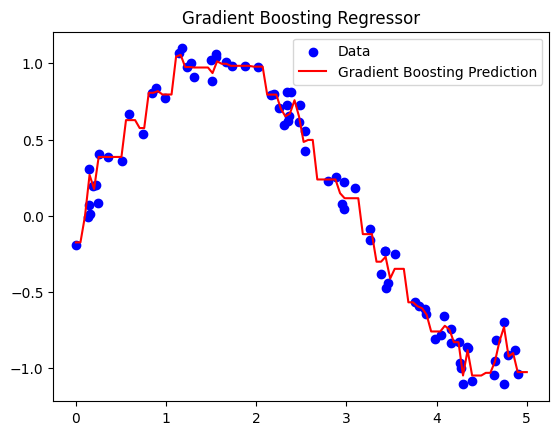

In [14]:
X_test = np.linspace(0, 5, 100).reshape(-1, 1)
y_pred = gradBoost.predict(X_test)


plt.scatter(X, y, color="blue", label="Data")
plt.plot(X_test, y_pred, color="red", label="Gradient Boosting Prediction")
plt.legend()
plt.title("Gradient Boosting Regressor")
plt.show()